##### Copyright 2020 The TensorFlow IO Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 Tensorflow-IO 从 Elasticsearch 流式传输结构化数据

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/io/tutorials/elasticsearch"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/io/tutorials/elasticsearch.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/io/tutorials/elasticsearch.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
      <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/io/tutorials/elasticsearch.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

## 概述

本教程侧重于将数据从 [Elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/elasticsearch-intro.html) 集群流式传输到 `tf.data.Dataset`，然后将其与 `tf.keras` 一起用于训练和推理。

Elasticseach 主要是一个分布式搜索引擎，支持存储结构化、非结构化、地理空间、数字数据等。出于本教程的目的，我们使用了具有结构化记录的数据集。

**注：**对 [elasticsearch 存储](https://www.elastic.co/guide/en/elasticsearch/reference/current/documents-indices.html)有个基本了解将帮助您轻松学习本教程。

## 安装数据包

`elasticsearch` 数据包用于在 elasticsearch 索引中准备和存储数据，仅用于演示目的。在具有大量节点的实际生产集群中，集群可能正在接收来自连接器（如 logstash 等）的数据。

一旦在 elasticsearch 集群中提供数据，只需 `tensorflow-io` 即可将数据流式传输到模型中。


### 安装所需的 tensorflow-io 和 elasticsearch 软件包

In [2]:
!pip install tensorflow-io
!pip install elasticsearch


### 导入软件包

In [3]:
import os
import time
from sklearn.model_selection import train_test_split
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_io as tfio

### 验证 tf 和 tfio 导入

In [4]:
print("tensorflow-io version: {}".format(tfio.__version__))
print("tensorflow version: {}".format(tf.__version__))

tensorflow-io version: 0.16.0
tensorflow version: 2.3.0


## 下载并设置 Elasticsearch 实例

出于演示目的，我们使用了 elasticsearch 软件包的开源版本。


In [5]:
%%bash

wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
wget -q https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512
tar -xzf elasticsearch-oss-7.9.2-linux-x86_64.tar.gz
sudo chown -R daemon:daemon elasticsearch-7.9.2/
shasum -a 512 -c elasticsearch-oss-7.9.2-linux-x86_64.tar.gz.sha512 

elasticsearch-oss-7.9.2-linux-x86_64.tar.gz: OK


将实例作为守护进程运行

In [6]:
%%bash --bg

sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch

Starting job # 0 in a separate thread.


In [7]:
# Sleep for few seconds to let the instance start.
time.sleep(20)

启动实例后，在进程列表中针对 `elasticsearch` 使用 grep 以确认可用性。

In [8]:
%%bash

ps -ef | grep elasticsearch

root         144     142  0 21:24 ?        00:00:00 sudo -H -u daemon elasticsearch-7.9.2/bin/elasticsearch
daemon       145     144 86 21:24 ?        00:00:17 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-16913031424109346409 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:fileco

查询基本端点以检索有关集群的信息。

In [9]:
%%bash

curl -sX GET "localhost:9200/"

{
  "name" : "d1bc7d054c69",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "P8YXfKqYS-OS3k9CdMmlsw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "oss",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


### 探索数据集

出于本教程的目的，让我们下载 [PetFinder](https://www.kaggle.com/c/petfinder-adoption-prediction) 数据集并手动将数据输入 elasticsearch。此分类问题的目标是预测宠物是否会被收养。


In [10]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'
tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
pf_df = pd.read_csv(csv_file)

1671168/1668792 [==============================] - 0s 0us/step


In [11]:
pf_df.head()

Type  Age  ... PhotoAmt AdoptionSpeed
0  Cat    3  ...        1             2
1  Cat    1  ...        2             0
2  Dog    1  ...        7             3
3  Dog    4  ...        8             2
4  Dog    1  ...        3             2

[5 rows x 15 columns]

出于本教程的目的，标签列已进行了修改。0 表示宠物未被领养，1 表示已领养。


In [12]:
# In the original dataset "4" indicates the pet was not adopted.
pf_df['target'] = np.where(pf_df['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns.
pf_df = pf_df.drop(columns=['AdoptionSpeed', 'Description'])


In [13]:
# Number of datapoints and columns
len(pf_df), len(pf_df.columns)

(11537, 14)

### 拆分数据集


In [14]:
train_df, test_df = train_test_split(pf_df, test_size=0.3, shuffle=True)
print("Number of training samples: ",len(train_df))
print("Number of testing sample: ",len(test_df))


Number of training samples:  8075
Number of testing sample:  3462


### 将训练和测试数据存储在 elasticsearch 索引中

将数据存储在本地 elasticsearch 集群中模拟的是用于连续检索远程数据的环境，其目的是进行训练和推理。

In [15]:
ES_NODES = "http://localhost:9200"

def prepare_es_data(index, doc_type, df):
  records = df.to_dict(orient="records")
  es_data = []
  for idx, record in enumerate(records):
    meta_dict = {
          "index": {
              "_index": index, 
              "_type": doc_type, 
              "_id": idx
          }
      }
    es_data.append(meta_dict)
    es_data.append(record)

  return es_data

def index_es_data(index, es_data):
  es_client = Elasticsearch(hosts = [ES_NODES])
  if es_client.indices.exists(index):
      print("deleting the '{}' index.".format(index))
      res = es_client.indices.delete(index=index)
      print("Response from server: {}".format(res))

  print("creating the '{}' index.".format(index))
  res = es_client.indices.create(index=index)
  print("Response from server: {}".format(res))

  print("bulk index the data")
  res = es_client.bulk(index=index, body=es_data, refresh = True)
  print("Errors: {}, Num of records indexed: {}".format(res["errors"], len(res["items"])))
  

In [16]:
train_es_data = prepare_es_data(index="train", doc_type="pet", df=train_df)
test_es_data = prepare_es_data(index="test", doc_type="pet", df=test_df)

index_es_data(index="train", es_data=train_es_data)
time.sleep(3)
index_es_data(index="test", es_data=test_es_data)

creating the 'train' index.
Response from server: {'acknowledged': True, 'shards_acknowledged': True, 'index': 'train'}
bulk index the data


/usr/local/lib/python3.6/dist-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: [types removal] Specifying types in bulk requests is deprecated.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


Errors: False, Num of records indexed: 8075
creating the 'test' index.
Response from server: {'acknowledged': True, 'shards_acknowledged': True, 'index': 'test'}
bulk index the data
Errors: False, Num of records indexed: 3462


## 准备 tfio 数据集

一旦在集群中提供数据，只需要 `tensorflow-io` 即可从索引中流式传输数据。 `elasticsearch.ElasticsearchIODataset` 类用于此目的。该类继承自 `tf.data.Dataset`，因此公开了 `tf.data.Dataset` 开箱即用的所有有用功能。


### 训练数据集


In [17]:
BATCH_SIZE=32
HEADERS = {"Content-Type": "application/json"}

train_ds = tfio.experimental.elasticsearch.ElasticsearchIODataset(
        nodes=[ES_NODES],
        index="train",
        doc_type="pet",
        headers=HEADERS
    )

# Prepare a tuple of (features, label)
train_ds = train_ds.map(lambda v: (v, v.pop("target")))
train_ds = train_ds.batch(BATCH_SIZE)

Connection successful: http://localhost:9200/_cluster/health


### 测试数据集

In [18]:
test_ds = tfio.experimental.elasticsearch.ElasticsearchIODataset(
        nodes=[ES_NODES],
        index="test",
        doc_type="pet",
        headers=HEADERS
    )

# Prepare a tuple of (features, label)
test_ds = test_ds.map(lambda v: (v, v.pop("target")))
test_ds = test_ds.batch(BATCH_SIZE)

Connection successful: http://localhost:9200/_cluster/health


### 定义 keras 预处理层

根据[结构化数据教程](https://tensorflow.google.cn/tutorials/structured_data/preprocessing_layers)，建议使用 [Keras 预处理层](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/experimental/preprocessing)，因为它们更直观，并且可以轻松地与模型集成。但是，也可以使用标准 [feature_columns](https://tensorflow.google.cn/api_docs/python/tf/feature_column)。

为了更好地了解结构化数据分类中的 `preprocessing_layers`，请参考[结构化数据教程](https://tensorflow.google.cn/tutorials/structured_data/preprocessing_layers)

In [19]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization()

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_values=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

  # Prepare a Dataset that only yields our feature.
  feature_ds = feature_ds.map(index)

  # Learn the space of possible indices.
  encoder.adapt(feature_ds)

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so you can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))


提取一个批次并观察示例记录的特征。这将有助于定义用于训练 `tf.keras` 模型的 keras 预处理层。

In [20]:
ds_iter = iter(train_ds)
features, label = next(ds_iter)
{key: value.numpy()[0] for key,value in features.items()}

{'Age': 2,
 'Breed1': b'Tabby',
 'Color1': b'Black',
 'Color2': b'Cream',
 'Fee': 0,
 'FurLength': b'Short',
 'Gender': b'Male',
 'Health': b'Healthy',
 'MaturitySize': b'Small',
 'PhotoAmt': 4,
 'Sterilized': b'No',
 'Type': b'Cat',
 'Vaccinated': b'No'}

选择某些特征。

In [21]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Categorical features encoded as string.
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)  

## 构建、编译并训练模型


In [22]:
# Set the parameters

OPTIMIZER="adam"
LOSS=tf.keras.losses.BinaryCrossentropy(from_logits=True)
METRICS=['accuracy']
EPOCHS=10


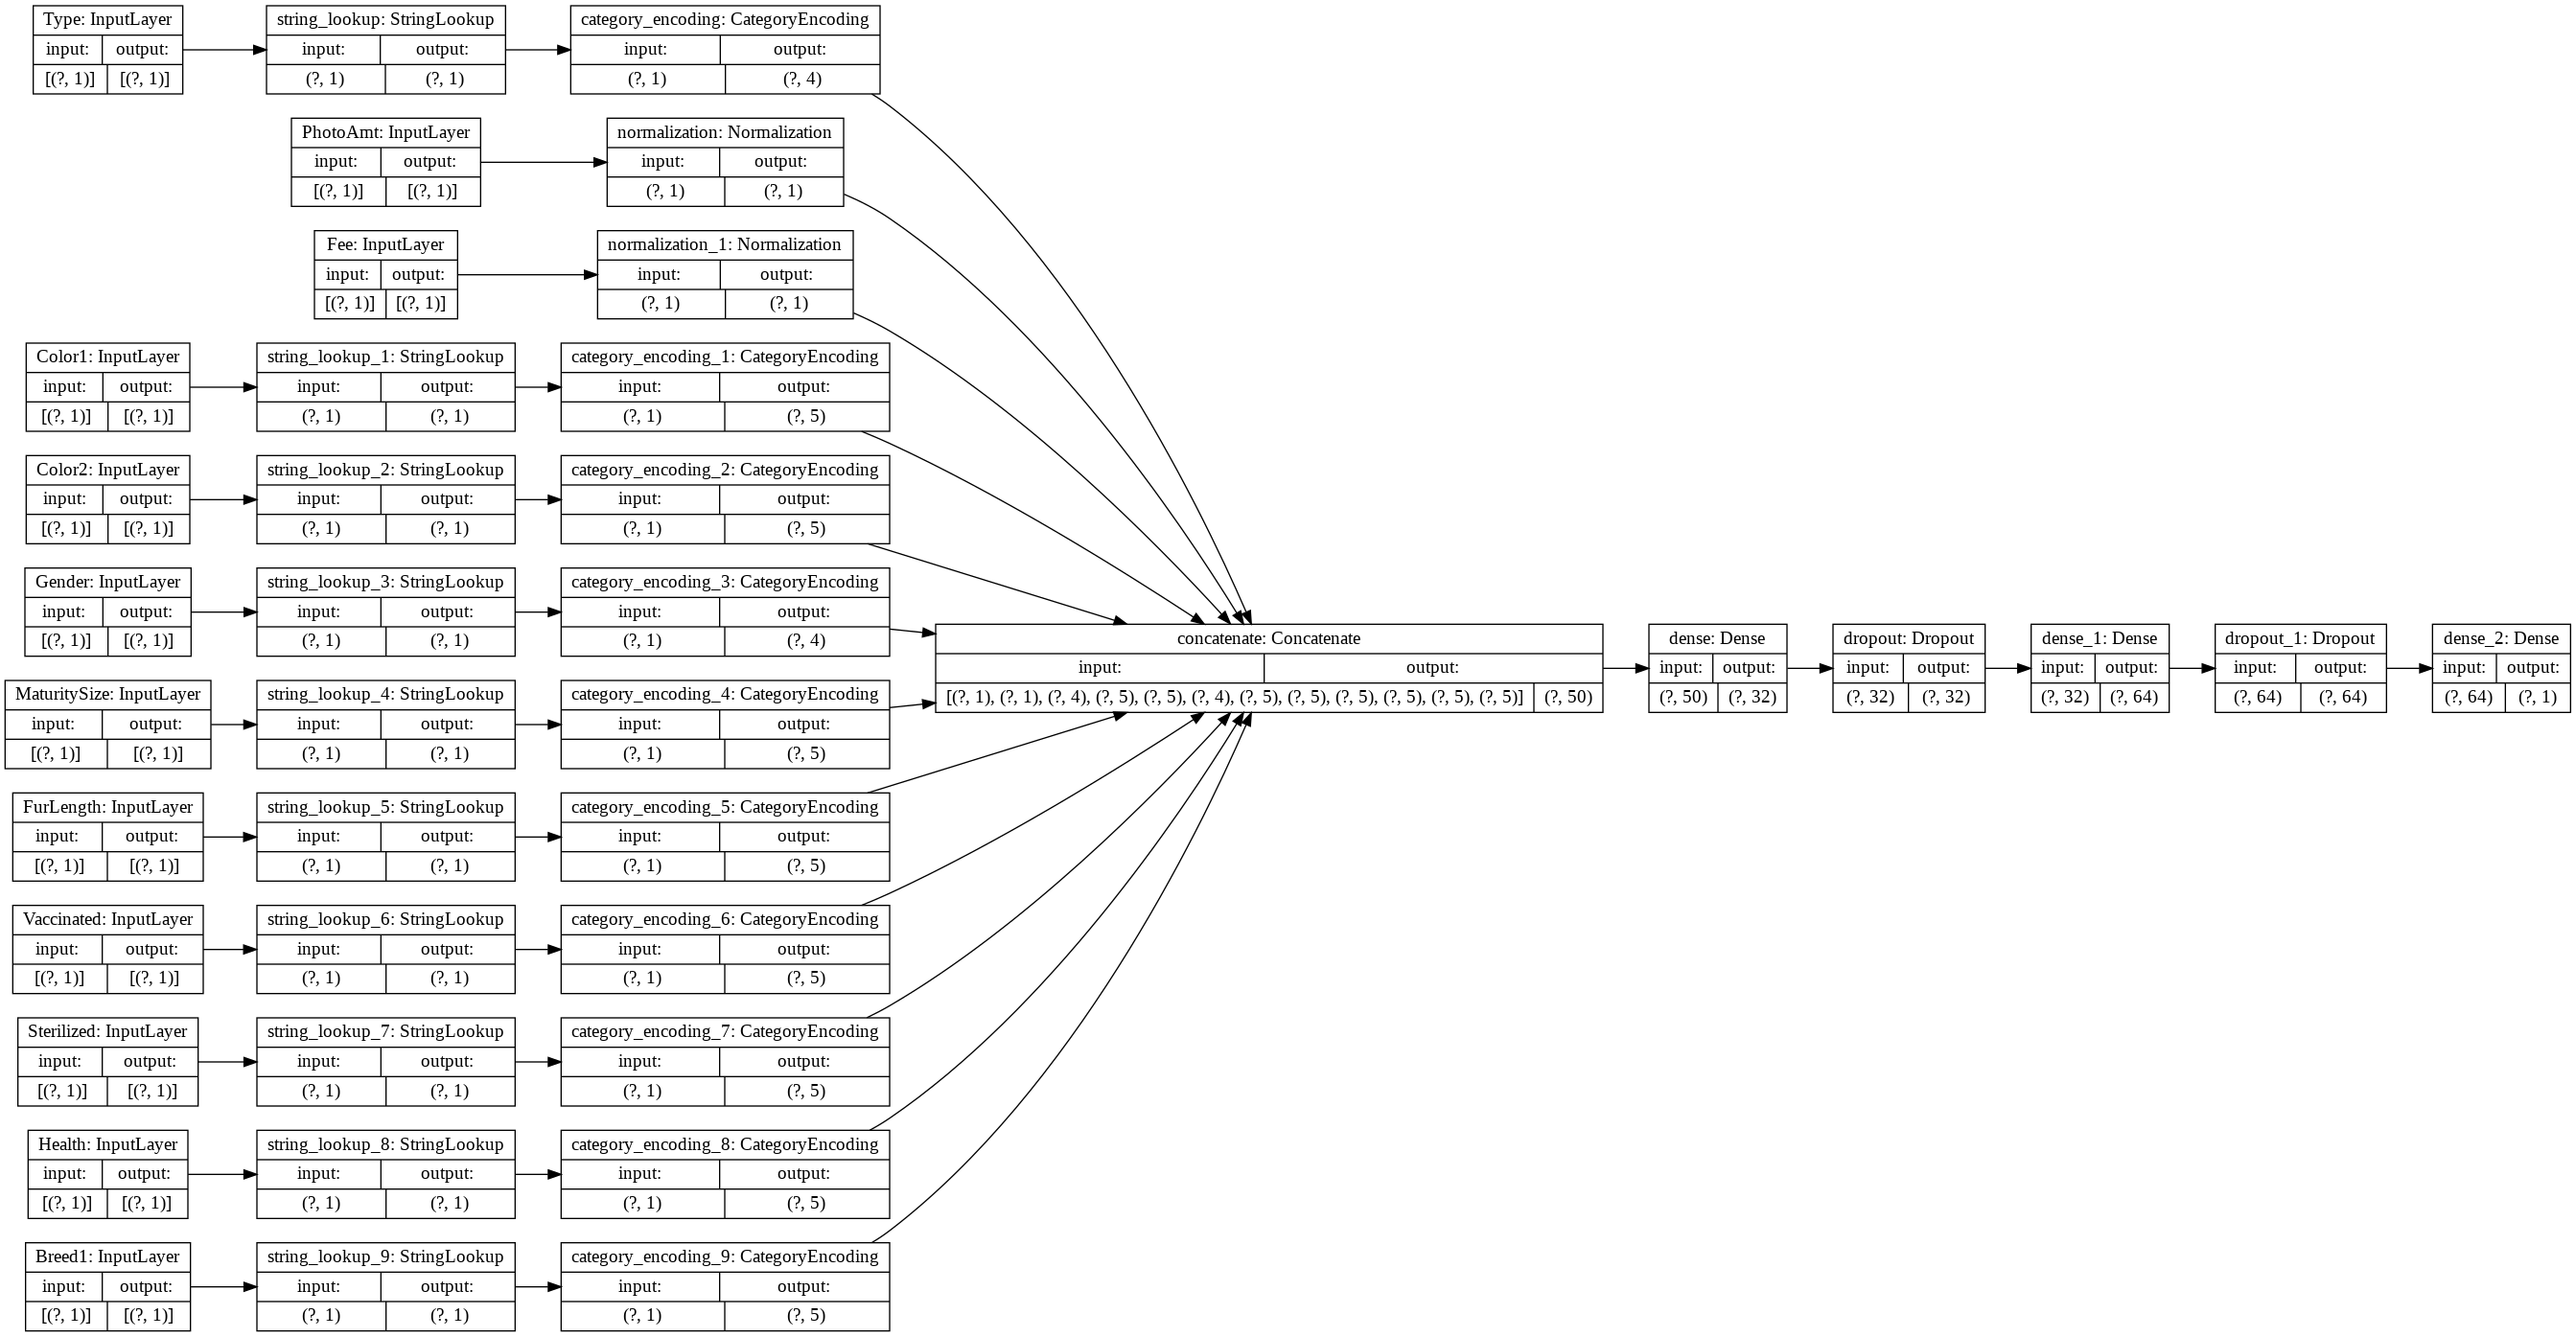

In [23]:
# Convert the feature columns into a tf.keras layer
all_features = tf.keras.layers.concatenate(encoded_features)

# design/build the model
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)

tf.keras.utils.plot_model(model, rankdir='LR', show_shapes=True)

In [24]:
# compile the model
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

In [25]:
# fit the model
model.fit(train_ds, epochs=EPOCHS)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['Age'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


253/253 [==============================] - 4s 14ms/step - loss: 0.6169 - accuracy: 0.6042
Epoch 2/10
253/253 [==============================] - 4s 14ms/step - loss: 0.5634 - accuracy: 0.6937
Epoch 3/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5573 - accuracy: 0.6981
Epoch 4/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5528 - accuracy: 0.7087
Epoch 5/10
253/253 [==============================] - 4s 14ms/step - loss: 0.5512 - accuracy: 0.7173
Epoch 6/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5456 - accuracy: 0.7219
Epoch 7/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5397 - accuracy: 0.7283
Epoch 8/10
253/253 [==============================] - 4s 14ms/step - loss: 0.5385 - accuracy: 0.7331
Epoch 9/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5355 - accuracy: 0.7326
Epoch 10/10
253/253 [==============================] - 4s 15ms/step - loss: 0.5412 - accuracy: 0.7321


## 基于测试数据进行推理

In [26]:
res = model.evaluate(test_ds)
print("test loss, test acc:", res)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['Age'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


109/109 [==============================] - 2s 15ms/step - loss: 0.5344 - accuracy: 0.7421
test loss, test acc: [0.534355640411377, 0.7420566082000732]


注：由于本教程的目标是演示 Tensorflow-IO 从 elasticsearch 流式传输数据和直接训练 `tf.keras` 模型的能力，因此提高模型的准确性不在当前范围之内。但是，用户可以探索数据集并使用特征列和模型架构来获得更好的分类性能。

## 参考：

- [Elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/targz.html)

- [PetFinder 数据集](https://www.kaggle.com/c/petfinder-adoption-prediction)

- [使用 Keras 对结构化数据进行分类](https://tensorflow.google.cn/tutorials/structured_data/preprocessing_layers#create_compile_and_train_the_model)
